In [89]:
import pandas as pd
import numpy as np
import jinja2
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.stats import poisson
import datetime

## Preprocessing BL

In [90]:
path_bundesliga = r"preprocessed_dataframe_with_elo_1.csv"
match_data_unfiltered = pd.read_csv(path_bundesliga, delimiter=",")
match_data_unfiltered.tail()
# match_data_unfiltered.info()
pd.to_datetime('30.06.2021')

Timestamp('2021-06-30 00:00:00')

In [91]:
match_data_unfiltered['Date'] = pd.to_datetime(match_data_unfiltered['Date'])
match_data_unfiltered = match_data_unfiltered.drop(["Unnamed: 0"], axis=1, errors="ignore")
# print(match_data_unfiltered.columns)
match_data_unfiltered.tail(n=5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HomeAttack,HomeDefend,AwayAttack,AwayDefend,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld,HomeEloOld,AwayEloOld
4891,2022-05-14,Mainz,Ein Frankfurt,2.0,2.0,D,1.0,2.0,A,13.0,...,2.001489,-1.884149,1.172358,-1.581157,1.868412,-1.545160,0.652603,-1.330148,849.372072,844.265646
4892,2022-05-14,M'gladbach,Hoffenheim,5.0,1.0,H,3.0,1.0,H,19.0,...,3.347095,-1.133621,1.647127,-4.249006,2.048918,-1.426219,2.062127,-3.467829,877.665071,855.590835
4893,2022-05-14,Stuttgart,FC Koln,2.0,1.0,H,1.0,0.0,H,24.0,...,1.491069,-1.100222,1.535998,-1.369941,0.963734,-1.335884,1.877641,-0.890119,734.655957,762.003692
4894,2022-05-14,Union Berlin,Bochum,3.0,2.0,H,2.0,0.0,H,17.0,...,2.870488,-1.234870,1.944127,-2.321089,2.570349,-0.727307,1.757577,-1.887840,746.240131,389.650242
4895,2022-05-14,Wolfsburg,Bayern Munich,2.0,2.0,D,1.0,2.0,A,10.0,...,1.994849,-1.248584,2.255671,-1.869960,1.949939,-0.849493,2.258790,-1.790906,825.333792,1118.372385


In [92]:
match_data_unfiltered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           4896 non-null   datetime64[ns]
 1   HomeTeam       4896 non-null   object        
 2   AwayTeam       4896 non-null   object        
 3   FTHG           4896 non-null   float64       
 4   FTAG           4896 non-null   float64       
 5   FTR            4896 non-null   object        
 6   HTHG           4896 non-null   float64       
 7   HTAG           4896 non-null   float64       
 8   HTR            4896 non-null   object        
 9   HS             4896 non-null   float64       
 10  AS             4896 non-null   float64       
 11  HST            4896 non-null   float64       
 12  AST            4896 non-null   float64       
 13  HF             4896 non-null   float64       
 14  AF             4896 non-null   float64       
 15  HC             4896 n

In [93]:
df_test = match_data_unfiltered[match_data_unfiltered['Date'] > pd.to_datetime('2021-06-30')]
match_data_unfiltered = match_data_unfiltered[(match_data_unfiltered.Date < pd.to_datetime('2021-06-30'))]#&(match_data_unfiltered.Date > pd.to_datetime('2015-06-30'))]
df_test

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HomeAttack,HomeDefend,AwayAttack,AwayDefend,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld,HomeEloOld,AwayEloOld
4410,2021-08-01,M'gladbach,Bayern Munich,3.0,2.0,H,2.0,2.0,D,8.0,...,2.240069,-1.371492,3.223870,-2.187781,1.493803,-1.360885,3.832490,-1.548463,857.598611,1073.187392
4411,2021-09-01,Freiburg,FC Koln,5.0,0.0,H,2.0,0.0,H,12.0,...,4.289963,-0.526902,-0.004429,-2.715384,3.104461,-0.862702,0.098294,-1.202607,764.861819,639.193632
4412,2021-09-01,Leverkusen,Werder Bremen,1.0,1.0,D,0.0,0.0,D,12.0,...,1.562984,-1.244477,0.534236,-1.327875,2.028214,-1.251897,0.303673,-1.637197,868.568978,649.742041
4413,2021-09-01,Mainz,Ein Frankfurt,0.0,2.0,A,0.0,1.0,A,8.0,...,0.337272,-2.347070,2.104636,-0.595728,0.743759,-2.602679,2.236832,-1.020619,661.989255,821.574041
4414,2021-09-01,Schalke 04,Hoffenheim,4.0,0.0,H,1.0,0.0,H,12.0,...,1.672543,-1.465030,0.611713,-3.064203,-0.116485,-2.598398,1.271747,-2.037234,657.727602,781.556074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,2022-05-14,Mainz,Ein Frankfurt,2.0,2.0,D,1.0,2.0,A,13.0,...,2.001489,-1.884149,1.172358,-1.581157,1.868412,-1.545160,0.652603,-1.330148,849.372072,844.265646
4892,2022-05-14,M'gladbach,Hoffenheim,5.0,1.0,H,3.0,1.0,H,19.0,...,3.347095,-1.133621,1.647127,-4.249006,2.048918,-1.426219,2.062127,-3.467829,877.665071,855.590835
4893,2022-05-14,Stuttgart,FC Koln,2.0,1.0,H,1.0,0.0,H,24.0,...,1.491069,-1.100222,1.535998,-1.369941,0.963734,-1.335884,1.877641,-0.890119,734.655957,762.003692
4894,2022-05-14,Union Berlin,Bochum,3.0,2.0,H,2.0,0.0,H,17.0,...,2.870488,-1.234870,1.944127,-2.321089,2.570349,-0.727307,1.757577,-1.887840,746.240131,389.650242


## Preprocessing PL

In [60]:
# read the csv file
path = r"history.csv"
# path = "preprocessed_dataframe_with_elo_1.csv"
match_data_unfiltered = pd.read_csv(path)

In [61]:
match_data_unfiltered = match_data_unfiltered[match_data_unfiltered['Season'].str.contains('201')]
match_data_unfiltered

,div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
6624,E0,14/08/10,Aston Villa,West Ham,3,0,H,2.0,0.0,H,2010-11
6625,E0,14/08/10,Blackburn,Everton,1,0,H,1.0,0.0,H,2010-11
6626,E0,14/08/10,Bolton,Fulham,0,0,D,0.0,0.0,D,2010-11
6627,E0,14/08/10,Chelsea,West Brom,6,0,H,2.0,0.0,H,2010-11
6628,E0,14/08/10,Sunderland,Birmingham,2,2,D,1.0,0.0,H,2010-11
...,...,...,...,...,...,...,...,...,...,...,...
9659,E0,13/05/18,Newcastle,Chelsea,3,0,H,1.0,0.0,H,2017-18
9660,E0,13/05/18,Southampton,Man City,0,1,A,0.0,0.0,D,2017-18
9661,E0,13/05/18,Swansea,Stoke,1,2,A,1.0,2.0,A,2017-18
9662,E0,13/05/18,Tottenham,Leicester,5,4,H,1.0,2.0,A,2017-18


In [62]:
# split train test data
# df_train = match_data_unfiltered[match_data_unfiltered.reset_index().index % 3 != 0]  # Excludes every 3rd row starting from 0
# df_test = match_data_unfiltered[match_data_unfiltered.reset_index().index % 3 == 0]  # Selects every 3rd row starting from 0
# match_data_unfiltered = df_train
# df_test = match_data_unfiltered[match_data_unfiltered['Season']=='2017-18']
# match_data_unfiltered = match_data_unfiltered[(match_data_unfiltered['Season'].str.contains('201'))&(match_data_unfiltered['Season']!='2017-18')]
df_test = match_data_unfiltered.iloc[-100:, :]
match_data_unfiltered = match_data_unfiltered.iloc[:-100,:]
df_test


,div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
9564,E0,3/3/2018,Burnley,Everton,2,1,H,0.0,1.0,A,2017-18
9565,E0,3/3/2018,Leicester,Bournemouth,1,1,D,0.0,1.0,A,2017-18
9566,E0,3/3/2018,Liverpool,Newcastle,2,0,H,1.0,0.0,H,2017-18
9567,E0,3/3/2018,Southampton,Stoke,0,0,D,0.0,0.0,D,2017-18
9568,E0,3/3/2018,Swansea,West Ham,4,1,H,2.0,0.0,H,2017-18
...,...,...,...,...,...,...,...,...,...,...,...
9659,E0,13/05/18,Newcastle,Chelsea,3,0,H,1.0,0.0,H,2017-18
9660,E0,13/05/18,Southampton,Man City,0,1,A,0.0,0.0,D,2017-18
9661,E0,13/05/18,Swansea,Stoke,1,2,A,1.0,2.0,A,2017-18
9662,E0,13/05/18,Tottenham,Leicester,5,4,H,1.0,2.0,A,2017-18


In [63]:
df_test

,div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
9564,E0,3/3/2018,Burnley,Everton,2,1,H,0.0,1.0,A,2017-18
9565,E0,3/3/2018,Leicester,Bournemouth,1,1,D,0.0,1.0,A,2017-18
9566,E0,3/3/2018,Liverpool,Newcastle,2,0,H,1.0,0.0,H,2017-18
9567,E0,3/3/2018,Southampton,Stoke,0,0,D,0.0,0.0,D,2017-18
9568,E0,3/3/2018,Swansea,West Ham,4,1,H,2.0,0.0,H,2017-18
...,...,...,...,...,...,...,...,...,...,...,...
9659,E0,13/05/18,Newcastle,Chelsea,3,0,H,1.0,0.0,H,2017-18
9660,E0,13/05/18,Southampton,Man City,0,1,A,0.0,0.0,D,2017-18
9661,E0,13/05/18,Swansea,Stoke,1,2,A,1.0,2.0,A,2017-18
9662,E0,13/05/18,Tottenham,Leicester,5,4,H,1.0,2.0,A,2017-18


## Data Knowledge

In [94]:
# winning_team

winning_team = match_data_unfiltered['FTR'].value_counts()
print(f"Gewinnchancen \nHome Team: {winning_team['H']/winning_team.sum()}")
print(f"Away Team: {winning_team['A']/winning_team.sum()}")
print(f"Draw: {winning_team['D']/winning_team.sum()}")

Gewinnchancen 
Home Team: 0.45
Away Team: 0.3041484716157205
Draw: 0.24585152838427948


## Modeltraining 

In [96]:
# make FTR column to continous variable
# def convert_ftr(result: str):
#     if result == "D":
#         return 2
#     elif result == "H":
#         return 3
#     elif result == "A":
#         return 1
#     else: 
#         return None
# match_data_unfiltered['FTR'] = match_data_unfiltered['FTR'].apply(convert_ftr)

In [97]:
# [match_data_unfiltered['Season'].str.contains('201')]

max prob mit einem Testdatensatz von 50: 58% 
komplette halbe Saison: 64%

In [98]:
# print correlation matrix
correlation_matrix_match_data_unfiltered = match_data_unfiltered.corr()
correlation_matrix_match_data_unfiltered.style.background_gradient()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HomeElo,AwayElo,HomeAttack,HomeDefend,AwayAttack,AwayDefend,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld,HomeEloOld,AwayEloOld
FTHG,1.000000,-0.114910,0.688667,-0.063317,0.281912,-0.118864,0.526890,-0.120225,-0.106302,-0.078435,0.029040,-0.069062,-0.126667,0.026202,-0.087961,0.070425,0.183184,-0.075588,0.817340,0.131681,-0.126775,-0.761550,0.210665,0.094667,-0.090202,-0.088586,0.154883,-0.047653
FTAG,-0.114910,1.000000,-0.073777,0.679777,-0.114325,0.296602,-0.119349,0.531831,-0.007256,-0.049034,-0.044779,0.055971,0.092804,-0.059546,0.138369,-0.061868,-0.056481,0.165544,-0.128489,-0.768551,0.715432,0.123922,-0.096563,-0.073384,0.155925,0.076307,-0.032733,0.141517
HTHG,0.688667,-0.073777,1.000000,-0.076107,0.122269,-0.055792,0.333647,-0.079453,-0.043827,-0.048420,-0.036457,-0.009861,-0.110668,0.017434,-0.032451,0.017780,0.120363,-0.048405,0.571014,0.091059,-0.078096,-0.515232,0.156831,0.070324,-0.054221,-0.048198,0.101260,-0.029545
HTAG,-0.063317,0.679777,-0.076107,1.000000,-0.018223,0.145946,-0.047166,0.331355,0.007305,-0.004791,0.031603,-0.004167,0.082726,-0.051447,0.068720,-0.001893,-0.033243,0.124701,-0.070592,-0.518740,0.494862,0.076445,-0.055263,-0.046729,0.117779,0.055014,-0.017408,0.108616
HS,0.281912,-0.114325,0.122269,-0.018223,1.000000,-0.320261,0.662941,-0.200030,-0.127800,0.035600,0.510584,-0.252147,-0.125430,0.051453,-0.111025,0.096689,0.059659,-0.189304,0.299010,0.130452,-0.179069,-0.253770,0.193111,0.111332,-0.166734,-0.103290,0.056269,-0.185689
AS,-0.118864,0.296602,-0.055792,0.145946,-0.320261,1.000000,-0.200515,0.673009,0.072801,-0.077853,-0.250826,0.476878,0.110268,-0.063092,0.099099,-0.080980,-0.121344,0.099688,-0.162169,-0.280913,0.289509,0.139498,-0.155336,-0.134884,0.167850,0.103794,-0.117250,0.095691
HST,0.526890,-0.119349,0.333647,-0.047166,0.662941,-0.200515,1.000000,-0.083612,-0.053365,0.029370,0.312753,-0.160204,-0.117934,0.031007,-0.092884,0.091587,0.012621,-0.238055,0.479506,0.144260,-0.169966,-0.410097,0.200607,0.123661,-0.150725,-0.072172,0.000365,-0.225382
AST,-0.120225,0.531831,-0.079453,0.331355,-0.200030,0.673009,-0.083612,1.000000,0.073722,-0.018380,-0.150603,0.315549,0.099930,-0.062046,0.092909,-0.058935,-0.162406,0.043044,-0.143175,-0.435190,0.414442,0.146897,-0.121714,-0.093935,0.136875,0.109371,-0.150494,0.031410
HF,-0.106302,-0.007256,-0.043827,0.007305,-0.127800,0.072801,-0.053365,0.073722,1.000000,0.342548,-0.090122,0.015528,0.325893,0.095641,0.075605,0.058980,-0.435300,-0.356766,-0.180673,-0.045034,-0.027585,0.067001,-0.185230,-0.074724,-0.025110,0.009040,-0.433855,-0.356007
AF,-0.078435,-0.049034,-0.048420,-0.004791,0.035600,-0.077853,0.029370,-0.018380,0.342548,1.000000,0.019904,-0.039132,0.077932,0.309922,0.027626,0.052428,-0.443707,-0.459710,-0.102685,0.010660,-0.113770,0.027101,-0.075516,-0.013820,-0.117618,-0.036090,-0.441062,-0.459918


In [99]:
history_pair_h = match_data_unfiltered.groupby(['HomeTeam', 'AwayTeam'])
ave_home_scored = history_pair_h['FTHG'].mean()
history_pair_a = match_data_unfiltered.groupby(['AwayTeam', 'HomeTeam'])
ave_away_scored = history_pair_a['FTAG'].mean()

ave_away_scored.keys()
ave_away_scored

AwayTeam   HomeTeam     
Aachen     Bayern Munich    1.000000
           Bielefeld        1.000000
           Bochum           2.000000
           Cottbus          2.000000
           Dortmund         0.000000
                              ...   
Wolfsburg  Schalke 04       1.200000
           St Pauli         1.000000
           Stuttgart        1.307692
           Union Berlin     2.000000
           Werder Bremen    1.666667
Name: FTAG, Length: 915, dtype: float64

In [100]:
# import numpy as np
home_goals_av = np.ones(100)
away_goals_av = np.ones(100)

for i in range(len(match_data_unfiltered)-1000):
    counter = i + 1000
    home_team = match_data_unfiltered['HomeTeam'].iloc[counter]
    away_team = match_data_unfiltered['AwayTeam'].iloc[counter]
    # print(match_data_unfiltered.iloc[counter])
    # print(home_team, away_team)
    # home_goals_av.append(av)

## Verbesserungen:
- nur direkten Vergleich nehmen, wenn Mannschaften mind. 5x gegeneinander gespielt haben
- immer alle Werte miteinbeziehen --> Testen ob besser
- Testen der Features mit ML
- Naive Bayes oder anderen ML (Poisson Regression Model) verwenden und Possion Verteilung verwenden

In [101]:
home_test = ave_home_scored.index[0][0]
away_test = ave_home_scored.index[0][1]
print(home_test)
t_ave_h_scored = ave_home_scored.loc[home_test].mean()
t_ave_h_scored

Aachen


1.6470588235294117

In [102]:
def get_score(home, away, nsim):
    result = []
    try:
        ave_h_scored = ave_home_scored.loc[home, away]#, ave_away_scored.loc(away)}
        ave_a_scored = ave_away_scored.loc[away, home]
        for i in range(nsim):
            h_scored = poisson.rvs(1, ave_h_scored)
            a_scored = poisson.rvs(1, ave_a_scored)
            result.append([h_scored, a_scored])
        return result

    except:
        # try:
        t_ave_h_scored = ave_home_scored.loc[home].mean()
        t_ave_h_conceded = ave_away_scored.loc[:, home].mean()
        t_ave_a_scored = ave_away_scored.loc[away].mean()
        t_ave_a_conceded = ave_home_scored.loc[:, away].mean()
        # except:
        #     return []

        for i in range(nsim):
            h_scored = poisson.rvs(1, (t_ave_h_scored+t_ave_a_conceded)/2)
            a_scored = poisson.rvs(1, (t_ave_a_scored+t_ave_h_conceded)/2)
            result.append([h_scored, a_scored])
        return result

    # return ave_h_scored, ave_a_scored
score_arsenal_wh = get_score(home_test, away_test, 1000)

In [103]:
# result = pd.DataFrame(columns=["Winner"])
alpha = 0.04
number_of_repetitions = 1000

def get_result_for_one_single_match(home_team, away_team):
    result = []
    x = get_score(home_team, away_team, number_of_repetitions)
    for i in x:
        if i[0] > i[1]:
            result.append('H')
        elif i[0] == i[1]:
            result.append('D')
        else:
            result.append('A')
    # if x == []:
    #     return None
    home_win = result.count('H')/len(result)
    away_win = result.count('A')/len(result)
    draw = result.count('D')/len(result)
    print(f"Probability for home win: {home_win}, Away_win: {away_win}, draw: {draw}, Teams: {home_team, away_team}")
    return 'H' if home_win > away_win and home_win > (draw+alpha) else 'A' if away_win > (draw+alpha) else 'D' 

In [104]:
df_test['PredictedResult'] = None
# df_test[]
# df_test = df_test.tail(n=100)
for i in df_test.index:
    home_team = df_test['HomeTeam'][i]
    away_team = df_test['AwayTeam'][i]
    df_test['PredictedResult'][i] = get_result_for_one_single_match(home_team, away_team)

Probability for home win: 0.3385, Away_win: 0.3471, draw: 0.3144, Teams: ("M'gladbach", 'Bayern Munich')


C:\Users\Phili\AppData\Local\Temp/ipykernel_6488/1684315969.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['PredictedResult'][i] = get_result_for_one_single_match(home_team, away_team)


Probability for home win: 0.6581, Away_win: 0.1318, draw: 0.2101, Teams: ('Freiburg', 'FC Koln')
Probability for home win: 0.3489, Away_win: 0.3394, draw: 0.3117, Teams: ('Leverkusen', 'Werder Bremen')
Probability for home win: 0.6528, Away_win: 0.1293, draw: 0.2179, Teams: ('Mainz', 'Ein Frankfurt')
Probability for home win: 0.6512, Away_win: 0.1289, draw: 0.2199, Teams: ('Schalke 04', 'Hoffenheim')
Probability for home win: 0.3468, Away_win: 0.3425, draw: 0.3107, Teams: ('Union Berlin', 'Wolfsburg')
Probability for home win: 0.1318, Away_win: 0.6544, draw: 0.2138, Teams: ('RB Leipzig', 'Dortmund')
Probability for home win: 0.8648, Away_win: 0.0406, draw: 0.0946, Teams: ('Augsburg', 'Stuttgart')
Probability for home win: 0.3461, Away_win: 0.344, draw: 0.3099, Teams: ('Bielefeld', 'Hertha')
Probability for home win: 0.3443, Away_win: 0.3464, draw: 0.3093, Teams: ('Hoffenheim', 'Ein Frankfurt')
Probability for home win: 0.6519, Away_win: 0.1348, draw: 0.2133, Teams: ('RB Leipzig', 'Augs

In [105]:
# df_test['True'] = df_test[df_test['FTR']==df_test['PredictedResult']]
# df_test['True'].count_values()

In [106]:
# df_test = df_test.dropna()
len(df_test[df_test['FTR']==df_test['PredictedResult']])/len(df_test)

0.4430379746835443

In [107]:
df_test['FTR'].value_counts()

H    145
A     91
D     80
Name: FTR, dtype: int64

In [108]:
df_test['PredictedResult'].value_counts()

H    155
A    105
D     56
Name: PredictedResult, dtype: int64

# Evaluation:
- Vergleich mit Wettanbierter --> Gewinn?

In [109]:
df_test.to_csv("predicted_season_17-18_PL.csv")

In [110]:
# filter for specific columns
# match_data_reduced = match_data_unfiltered.loc[:, ["FTR", "FTHG", "FTAG", "HomeElo", "AwayElo", "HomeAttack", "HomeDefend", "AwayAttack", "AwayDefend"]]
# "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
    # "AwayAttackOld", "AwayDefendOld"
# print correlation matrix
match_data_reduced = match_data_unfiltered.loc[:, ["FTR", "FTHG", "FTAG", "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld", "AwayAttackOld", "AwayDefendOld"]]

correlation_matrix_match_data_reduced = match_data_reduced.corr()
correlation_matrix_match_data_reduced.style.background_gradient()

,FTHG,FTAG,HomeEloOld,AwayEloOld,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld
FTHG,1.000000,-0.114910,0.154883,-0.047653,0.210665,0.094667,-0.090202,-0.088586
FTAG,-0.114910,1.000000,-0.032733,0.141517,-0.096563,-0.073384,0.155925,0.076307
HomeEloOld,0.154883,-0.032733,1.000000,0.683097,0.309364,0.075215,0.034811,-0.055042
AwayEloOld,-0.047653,0.141517,0.683097,1.000000,0.054791,-0.053721,0.305690,0.093183
HomeAttackOld,0.210665,-0.096563,0.309364,0.054791,1.000000,0.190987,0.011542,0.012218
HomeDefendOld,0.094667,-0.073384,0.075215,-0.053721,0.190987,1.000000,-0.017772,0.023661
AwayAttackOld,-0.090202,0.155925,0.034811,0.305690,0.011542,-0.017772,1.000000,0.188536
AwayDefendOld,-0.088586,0.076307,-0.055042,0.093183,0.012218,0.023661,0.188536,1.000000


In [111]:
X = match_data_unfiltered.loc[:, ["HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
    "AwayAttackOld", "AwayDefendOld"
]]

# use full time home goals and full time away goals; alternatively also using result directly is possible
y = match_data_unfiltered.loc[:, ["FTHG", "FTAG"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# X_train, y_train = X, y

In [112]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [113]:
# clf.predict(X_test)

In [114]:
# result = clf.score(X_test, y_test)

In [115]:
# result

In [116]:
# class_names = {
#     'Away'
#     ,'Draw',
#     'Home'
# }
# # Plot non-normalized confusion matrix
# titles_options = [
#     ("Confusion matrix, without normalization", None),
#     ("Normalized confusion matrix", "true"),
# ]
# for title, normalize in titles_options:
#     disp = ConfusionMatrixDisplay.from_estimator(
#         clf,
#         X_test,
#         y_test,
#         #display_labels=class_names,
#         cmap=plt.cm.Blues,
#         normalize=normalize,
#     )
#     disp.ax_.set_title(title)

#     print(title)
#     print(disp.confusion_matrix)

# plt.show()

In [117]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import backend, callbacks
#create model
model = Sequential()

#get number of columns in training data
n_cols_2 = X_train.shape[1]
print(n_cols_2)

#add layers to model
model.add(Dense(10, activation='relu', input_shape=(n_cols_2, )))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(2, activation='softmax'))

#compile model using accuracy to measure model performance
# model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], metrics=['accuracy'])
model.compile(metrics=['accuracy'], optimizer='rmsprop', 
              loss='categorical_crossentropy')
# K.set_value(model.optimizer.learning_rate, 0.01)

# early_stopping_monitor = EarlyStopping(patience=3)

es = callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) 


history = model.fit(X_train, y_train,  epochs=30, batch_size = 500, validation_split=0.3) #, callbacks=[early_stopping_monitor]) #callbacks=[es],

6
Epoch 1/30
5/5 [==============================] - 1s 47ms/step - loss: 20.7369 - accuracy: 0.6968 - val_loss: 3.0653 - val_accuracy: 0.6678
Epoch 2/30
5/5 [==============================] - 0s 8ms/step - loss: 4.0100 - accuracy: 0.6656 - val_loss: 4.2642 - val_accuracy: 0.7014
Epoch 3/30
5/5 [==============================] - 0s 10ms/step - loss: 4.0488 - accuracy: 0.6465 - val_loss: 2.5057 - val_accuracy: 0.5071
Epoch 4/30
5/5 [==============================] - 0s 9ms/step - loss: 4.5565 - accuracy: 0.5491 - val_loss: 3.7609 - val_accuracy: 0.3290
Epoch 5/30
5/5 [==============================] - 0s 10ms/step - loss: 3.9284 - accuracy: 0.5431 - val_loss: 4.7801 - val_accuracy: 0.6992
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 4.3312 - accuracy: 0.5375 - val_loss: 2.8857 - val_accuracy: 0.4701
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 3.7965 - accuracy: 0.5319 - val_loss: 2.5675 - val_accuracy: 0.6471
Epoch 8/30
5/5 [============

In [118]:
model.evaluate(X_test, y_test)

48/48 [==============================] - 0s 1ms/step - loss: 18.3325 - accuracy: 0.3981


[18.33251190185547, 0.39814814925193787]

In [119]:
test = model.predict(X_test)
winning_team = []
for item in test:
    if abs(item[0]-item[1]) < 0.5:
        winning_team.append(2)
    elif item[0] > item[1]:
        winning_team.append(3)
    else:
        winning_team.append(1)
#   if result == "D":
#         return 2
#     elif result == "H":
#         return 3
#     elif result == "A":
#         return 1
winning_team.count(2)

78

In [120]:
winning_team_test = []
for item in np.array(y_test):
    if item[0] > item[1]:
        winning_team_test.append(3)
    elif item[0] == item[1]:
        winning_team_test.append(2)
    else:
        winning_team_test.append(1)
len(winning_team)

1512

In [121]:
y_test
test

array([[2.2999445e-09, 1.0000000e+00],
       [2.3156881e-14, 1.0000000e+00],
       [1.0525771e-10, 1.0000000e+00],
       ...,
       [1.7879525e-02, 9.8212045e-01],
       [3.6124049e-05, 9.9996388e-01],
       [3.2857720e-08, 1.0000000e+00]], dtype=float32)

In [122]:
counter = 0
for i in range(len(winning_team)):
    if winning_team[i] == winning_team_test[i]:
        counter += 1
counter/len(winning_team)

0.36706349206349204

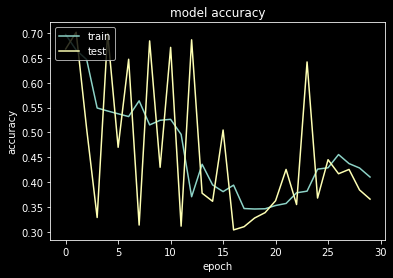

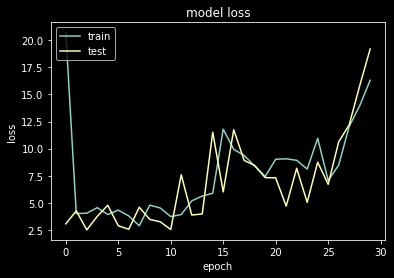

In [123]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()

# summarize history for loss

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()